In [1]:
import gym
import numpy as np

In [ ]:
env = gym.make(
    "reference_environment:rangl-nztc-v0"
)
env.param.noise_observability = False

In [3]:
env.action_space

Box([0. 0. 0.], [27. 25. 24.], (3,), float32)

In [43]:
# test policy function changed so that default testing is on multiple seeds

def test_policy(policy, seeds = [1]):
    '''
    test a policy
    '''
    rewards = []
    for seed in seeds:
        env.seed(seed)
        env.reset()
        done = False
        i = 0
        reward = 0
        while not done:
            state, rew, done, _ = env.step(policy[i,:])
            i += 1
            reward += rew
        rewards.append(reward)
    return rewards

### Genetic

In [12]:
def save_best(population, q = 0.85, pr = True):
    '''
    genetic function 1: keeps only the best of the population
    '''
    evals = np.zeros(len(population))
    for i in range(len(population)):
        evals[i] = test_policy(population[i])
    tresh = np.quantile(evals, q)
    ret = []
    for i in range(len(population)):
        if evals[i]>=tresh:
            ret.append(population[i])
    if pr:
        print('Mean test = '+str(np.mean(evals)))
    return ret

def populate(population, N=100, sd=0.5):
    '''
    genetic function 2: lets every element vary with a random noise
    '''
    while len(population)<N:
        i = np.random.randint(0,len(population))
        noise = sd*np.random.randn(20,3)
        population.append(np.maximum(population[i]+noise, np.zeros((20,3))))
        

In [16]:
'''
This policy was suggested by the organizer
'''

default_policy = np.zeros((20,3))
for i in range(20):
    if i == 12:
        default_policy[i,:] = np.array([1.,1.,2.])
    else:
        default_policy[i,:] = np.array([2.,2.,5.])
        
print('Default policy performance', test_policy(default_policy))

Default policy performance 635772.9978027344


If you do not want to reoptimize the genetic algo, load the pickle and skip the section after.

In [215]:
import joblib
import pickle 

#best = joblib.load("genetic.pkl")
#joblib.dump(best, "genetic.pkl")

['genetic.pkl']

In [17]:
population = []
for i in range(20):
    population.append(np.copy(default_policy))
    
G = 100
for i in range(G):
    print('Generation {} started'.format(i))
    population = save_best(population)
    populate(population)
    
best = save_best(population, q = 0.95, pr = True)

In [178]:
seeds_tr = np.arange(0,5)
def tuning(trial):
    leng = 60
    policy = [0]*leng
    for i in range(leng):
        policy[i] = trial.suggest_uniform('tr_leng'+str(i), 0, 100)
        
    policy = np.reshape(policy, (20,3))
        
    rews = test_policy(policy, seeds = seeds_tr)
    ci = CI(rews)
    return ci[0]

### Bayesian optimization

Simple bayesian optimization procedure with Optuna using a vanilla TPESampler. 
The following callback reduces Optuna's verbosity to just printing when finding improved solutions.

In [179]:
optuna.logging.set_verbosity(optuna.logging.WARN)
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [187]:
def to_optuna(pol):
    policies = {}
    count = 0
    for i in pol.ravel(order="A"):
        policies['tr_leng'+str(count)]=i
        count += 1
    return policies

def from_optuna(pol):
    policies = []
    count = 0
    for i in pol:
        policies.append(pol['tr_leng'+str(count)])
        count += 1
    policies = np.reshape(policies, (20,3))
    return policies

If you do not want to rerun the study, load the pickle and skip the section after.

In [214]:
import optuna 

#study = joblib.load("500trials_BO_5seeds.pkl")
#joblib.dump(study, "500trials_BO_5seeds.pkl")

['500trials_BO_5seeds.pkl']

In [ ]:
study = optuna.create_study(direction = 'maximize', sampler=optuna.samplers.TPESampler(), study_name = "Open_loop")

for i in range(len(best)):
    study.enqueue_trial(to_optuna(best[i]))

study.optimize(tuning, n_trials = 500, callbacks=[logging_callback])

### Benchmarking

Here, we load some standard policies to benchmark against.

In [182]:
import pandas as pd

def storm_agent(seeds):
        rewards = []
        deployments = np.array(np.array(pd.read_excel('./scenario_agents_actions/STORM_Deployments_Modified.xlsx'))[-(env.param.steps_per_episode+1):,1:],
                               dtype=np.float32)
        actions = deployments[1:,:] - deployments[:-1,:]
        for seed in seeds:
            env.seed(seed)
            env.reset()
            while not env.state.is_done():
                action = actions[env.state.step_count + 1]
                env.step(action)
            rewards.append(sum(env.state.rewards_all))
        return rewards
    
def breeze_agent(seeds):
        rewards = []
        deployments = np.array(np.array(pd.read_excel('./scenario_agents_actions/BREEZE_Deployments_Modified.xlsx'))
                               [-(env.param.steps_per_episode+1):,1:],dtype=np.float32)
        actions = deployments[1:,:] - deployments[:-1,:]
        for seed in seeds:
            env.seed(seed)
            env.reset()
            while not env.state.is_done():
                action = actions[env.state.step_count + 1]
                env.step(action)
            rewards.append(sum(env.state.rewards_all))
        return rewards

def gale_agent(seeds):
    rewards = []
    deployments = np.array(np.array(pd.read_excel('./scenario_agents_actions/GALE_Deployments_Modified.xlsx'))
                           [-(env.param.steps_per_episode+1):,1:],dtype=np.float32)
    actions = deployments[1:,:] - deployments[:-1,:]
    for seed in seeds:
        env.seed(seed)
        env.reset()
        while not env.state.is_done():
            action = actions[env.state.step_count + 1]
            env.step(action)
        rewards.append(sum(env.state.rewards_all))
    return rewards

    
def random_agent(seeds):
    rewards = []
    for seed in seeds:
        env.seed(seed)
        env.reset()
        while not env.state.is_done():
            action = env.action_space.sample()
            env.step(action)
        rewards.append(sum(env.state.rewards_all))
    return rewards

In [122]:
import scipy.stats as ss
n = 100
seeds = np.arange(100,n+100)

def CI(rews, alpha = 0.95):
    rews = [i/100000 for i in rews]
    mean = np.mean(rews)
    sd = np.std(rews)
    n = len(rews)
    return np.round(mean - sd * ss.t.ppf(1-(1-alpha)/2, n-1)/ np.sqrt(n), 1), np.round(mean + sd * ss.t.ppf(1-(1-alpha)/2, n-1)/ np.sqrt(n),1)

In [123]:
print("Best genetic: ", CI(test_policy(best[0], seeds = seeds)))

Best genetic:  (30.4, 34.6)


In [125]:
print("Random policy: ", CI(random_agent(seeds = seeds)))

Random policy:  (-2.2, 0.6)


In [124]:
print("Default policy: ", CI(test_policy(default_policy, seeds = seeds)))

Default policy:  (5.4, 6.1)


In [126]:
print("Breeze policy: ", CI(breeze_agent(seeds = seeds)))

Breeze policy:  (8.2, 9.0)


In [127]:
print("Gale policy: ", CI(gale_agent(seeds = seeds)))

Gale policy:  (10.9, 12.3)


In [128]:
print("Storm policy: ", CI(storm_agent(seeds = seeds)))

Storm policy:  (11.7, 13.7)


In [191]:
print("BO policy: ", CI(test_policy(from_optuna(study.best_params), seeds = seeds)))

BO policy:  (56.1, 64.3)


### BO solutions' analysis

<ipython-input-212-471f79a759ba>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

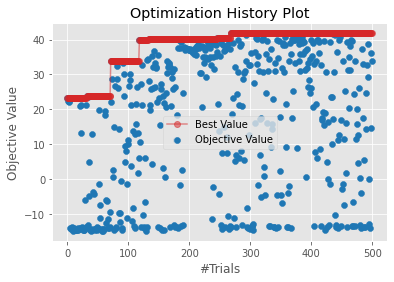

In [212]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [209]:
#these are hella weird fanova results
imp = optuna.importance.FanovaImportanceEvaluator()
imp.evaluate(study)

OrderedDict([('tr_leng49', 0.13472481880418014),
             ('tr_leng22', 0.10038678265642469),
             ('tr_leng59', 0.07757695845509534),
             ('tr_leng14', 0.07518501765923669),
             ('tr_leng57', 0.07090380479358391),
             ('tr_leng8', 0.05549299388325403),
             ('tr_leng9', 0.047609118248576346),
             ('tr_leng23', 0.04633366440557109),
             ('tr_leng29', 0.03530115382136999),
             ('tr_leng36', 0.03292302223128903),
             ('tr_leng28', 0.022683629482146958),
             ('tr_leng34', 0.02014217538781996),
             ('tr_leng16', 0.019860427226492675),
             ('tr_leng48', 0.019312589238828105),
             ('tr_leng17', 0.019205878028116078),
             ('tr_leng27', 0.017496036137856923),
             ('tr_leng12', 0.01679493029919235),
             ('tr_leng3', 0.014344277657296407),
             ('tr_leng32', 0.013135730589339511),
             ('tr_leng0', 0.012974573161137143),
             ('

In [218]:
# we might use this to train some ml model to learn the transitions in the world
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_tr_leng0,params_tr_leng1,params_tr_leng10,params_tr_leng11,params_tr_leng12,...,params_tr_leng56,params_tr_leng57,params_tr_leng58,params_tr_leng59,params_tr_leng6,params_tr_leng7,params_tr_leng8,params_tr_leng9,system_attrs_fixed_params,state
0,0,23.2,2022-01-24 15:41:22.809529,2022-01-24 15:41:24.235753,0 days 00:00:01.426224,5.634304,7.316352,9.617812,18.303187,1.672042,...,5.274169,23.097366,7.501486,35.079882,1.434977,8.063622,10.351713,0.326878,"{'tr_leng0': 5.634303803110234, 'tr_leng1': 7....",COMPLETE
1,1,22.5,2022-01-24 15:41:22.809529,2022-01-24 15:41:25.681845,0 days 00:00:02.872316,2.185352,6.811340,11.927183,21.823755,2.020615,...,5.344566,20.236872,7.747131,35.768408,1.142324,8.922184,7.482048,0.000000,"{'tr_leng0': 2.1853516461721165, 'tr_leng1': 6...",COMPLETE
2,2,22.4,2022-01-24 15:41:22.809529,2022-01-24 15:41:27.293533,0 days 00:00:04.484004,2.637113,6.826052,5.675558,17.114745,2.150722,...,7.624058,19.661700,7.421946,36.347770,2.011983,6.766495,7.600733,2.413406,"{'tr_leng0': 2.6371125103022246, 'tr_leng1': 6...",COMPLETE
3,3,22.0,2022-01-24 15:41:22.809529,2022-01-24 15:41:28.701469,0 days 00:00:05.891940,4.393647,6.438777,11.161822,19.081654,0.000000,...,5.231175,19.057959,4.589251,35.137173,0.004097,6.960962,8.958971,0.806233,"{'tr_leng0': 4.393646685339862, 'tr_leng1': 6....",COMPLETE
4,4,23.1,2022-01-24 15:41:22.810550,2022-01-24 15:41:30.153547,0 days 00:00:07.342997,5.365830,8.348348,8.960549,19.549655,0.793570,...,5.371970,23.050815,6.355176,34.909004,1.265695,8.410529,9.222989,0.000000,"{'tr_leng0': 5.365830253771055, 'tr_leng1': 8....",COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,-0.1,2022-01-24 15:59:21.695132,2022-01-24 15:59:24.305605,0 days 00:00:02.610473,45.104035,18.302847,59.474805,14.696049,29.786500,...,2.861110,70.984891,47.456901,94.932650,9.248073,51.176571,8.417701,89.187871,NaN,COMPLETE
496,496,-14.2,2022-01-24 15:59:24.307596,2022-01-24 15:59:26.998401,0 days 00:00:02.690805,29.052809,10.055908,54.903468,5.705262,41.369785,...,2.307652,73.036868,57.845423,92.849472,7.329786,53.859019,10.366463,85.121922,NaN,COMPLETE
497,497,14.7,2022-01-24 15:59:26.999398,2022-01-24 15:59:28.863452,0 days 00:00:01.864054,37.650066,12.448396,61.034119,9.554817,34.387540,...,6.156278,76.714390,56.110022,98.308564,56.433178,58.389761,13.973848,24.374722,NaN,COMPLETE
498,498,36.0,2022-01-24 15:59:28.865443,2022-01-24 15:59:30.703489,0 days 00:00:01.838046,48.762111,71.890498,47.299539,12.364752,44.153383,...,4.148194,68.732084,49.885807,99.938872,46.041862,56.299833,16.688893,93.393419,NaN,COMPLETE


In [33]:
best[0]

array([[ 5.6343038 ,  7.31635202,  1.04764082],
       [ 7.11204356,  6.41293783,  8.59869597],
       [ 1.43497739,  8.06362219, 10.35171344],
       [ 0.32687801,  9.61781173, 18.30318662],
       [ 1.67204239,  4.30744581,  6.87910739],
       [ 7.11997416,  9.6087187 ,  2.08295828],
       [ 6.96856308,  5.03822311,  8.06581453],
       [10.73024393,  0.        ,  0.63671874],
       [13.25631509,  0.        ,  9.68204517],
       [ 0.2727848 ,  3.83393124,  0.95144656],
       [ 2.31735592,  3.72031839,  0.33757205],
       [ 0.29040397,  0.        , 13.30277209],
       [ 2.41813802,  7.48978664,  0.10510811],
       [ 5.69475841,  2.95852143,  0.20538076],
       [ 0.99934783, 14.76048492,  2.47227299],
       [ 8.60948315, 13.21268992, 10.0593964 ],
       [ 1.91417127,  2.33944804,  7.27155397],
       [ 5.9627084 ,  0.57227365,  3.05363263],
       [ 6.71517223,  4.90494494,  5.27416879],
       [23.09736591,  7.50148603, 35.07988178]])

In [203]:
sum(best[0])

array([112.54703132, 111.65899658, 143.76106708])

In [197]:
params = from_optuna(study.best_params)

In [205]:
np.set_printoptions(suppress=True)
print(params)
sum(params)

[[34.06098921 35.10157699  1.96883022]
 [ 8.15768141 27.74061357  3.78296749]
 [ 3.54308994 39.95603924  0.08742552]
 [93.4220143  68.83593414 18.86210422]
 [91.1018146  53.91288973  0.00937667]
 [10.25363548 89.16170143  5.60669984]
 [17.68934498 13.02025925 20.05841931]
 [23.12969423 94.50491924  2.44392807]
 [38.04449519 16.62203998  0.06062715]
 [18.87386982 32.57907884  0.27147199]
 [ 9.20220743 76.40191643  6.75912408]
 [71.59111116  2.75981099  9.98611507]
 [ 8.66206711 21.22874917  0.10343962]
 [27.99018467 14.08841979 20.53984744]
 [39.00127893 29.48090945 23.78639934]
 [53.4416578   0.11025784 10.03698162]
 [ 1.27820473 65.68902876  4.36842314]
 [45.44466506 16.05524783  2.88365504]
 [94.51339922 15.43902904  9.31175703]
 [65.00215315 12.15373248 99.75717375]]


array([754.40355842, 724.84215418, 240.68476663])

In [222]:
joblib.dump(params, "optimal_policy.pkl")

['optimal_policy.pkl']

In [221]:
print(list(params))

[array([34.06098921, 35.10157699,  1.96883022]), array([ 8.15768141, 27.74061357,  3.78296749]), array([ 3.54308994, 39.95603924,  0.08742552]), array([93.4220143 , 68.83593414, 18.86210422]), array([91.1018146 , 53.91288973,  0.00937667]), array([10.25363548, 89.16170143,  5.60669984]), array([17.68934498, 13.02025925, 20.05841931]), array([23.12969423, 94.50491924,  2.44392807]), array([38.04449519, 16.62203998,  0.06062715]), array([18.87386982, 32.57907884,  0.27147199]), array([ 9.20220743, 76.40191643,  6.75912408]), array([71.59111116,  2.75981099,  9.98611507]), array([ 8.66206711, 21.22874917,  0.10343962]), array([27.99018467, 14.08841979, 20.53984744]), array([39.00127893, 29.48090945, 23.78639934]), array([53.4416578 ,  0.11025784, 10.03698162]), array([ 1.27820473, 65.68902876,  4.36842314]), array([45.44466506, 16.05524783,  2.88365504]), array([94.51339922, 15.43902904,  9.31175703]), array([65.00215315, 12.15373248, 99.75717375])]


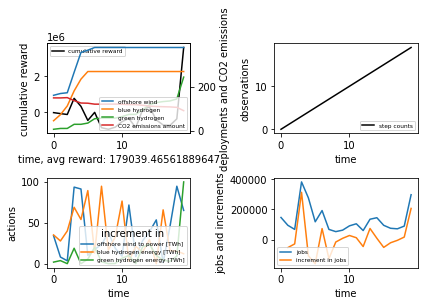

In [201]:
env.plot()